<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/master/SimpleMLFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.optimize import minimize

In [2]:
!pip install probfit

    100% |████████████████████████████████| 1.2MB 7.6MB/s 
    100% |████████████████████████████████| 501kB 11.6MB/s 
  Running setup.py bdist_wheel for probfit ... - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/0e/29/5c/c8328c35a857c819cceb4fa4828a419915a34b2e80f9a0fbc4
  Running setup.py bdist_wheel for iminuit ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/f0/af/3b/6667c485636f00d8d6ed7cdc120146ab47beb4db62c6c715b9
Successfully built probfit iminuit


In [0]:
import probfit
import iminuit

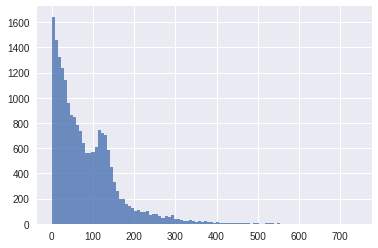

In [4]:
signal = np.random.normal(loc=125.18, scale=15., size=2000)
background = np.random.exponential(scale=80., size=18000)

data = np.concatenate([signal, background])
np.random.shuffle(data)

plt.hist(data, bins=100, alpha=0.8);

In [0]:
def SignalPDF(x, mass, sigma):
  return stats.norm.pdf(x, loc=mass, scale=sigma)

def BgPDF(x, exp_slope):
  return stats.expon.pdf(x, scale=1./exp_slope)

ModelPDF = probfit.AddPdfNorm(SignalPDF, BgPDF, facname=['signal_fraction'])

In [0]:
mass_bound = (10., 200.)
normed_pdf = probfit.Normalized(ModelPDF, mass_bound)

In [14]:
print(iminuit.describe(normed_pdf))

['x', 'mass', 'sigma', 'exp_slope', 'signal_fraction']


In [0]:
data = data[(data > mass_bound[0]) & (data < mass_bound[1])]

In [0]:
unbinned_likelihood = probfit.UnbinnedLH(normed_pdf, data)
initial_par_values = dict(
  mass           =120.  ,
  sigma          = 25.  ,
  exp_slope      =  0.01,
  signal_fraction=  0.4 ,
)

limits = dict(
  limit_mass           =(50. , 200.),
  limit_sigma          =( 3. , 150.),
  limit_exp_slope      =(1e-4,   1.),
  limit_signal_fraction=( 0. ,   1.),
)

errors = dict(
  error_mass           =10.  ,
  error_sigma          =10.  ,
  error_exp_slope      =0.005,
  error_signal_fraction=0.2  ,
)

minuit = iminuit.Minuit(
            unbinned_likelihood, **initial_par_values, **limits, **errors)

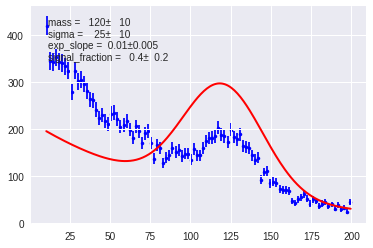

In [20]:
unbinned_likelihood.draw(minuit=minuit);

In [21]:
%timeit -n1 -r1 minuit.migrad()

FCN = 83481.08305811594 
 TOTAL NCALL = 183 
 NCALLS = 183 
 
 
 EDM = 7.671327826786293e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,125.12,0.674671,,,50,200,No
1,sigma,15.4371,0.751386,,,3,150,No
2,exp_slope,0.0128911,0.000241409,,,0.0001,1,No
3,signal_fraction,0.104497,0.00568799,,,0,1,No


1 loop, best of 1: 9min 40s per loop


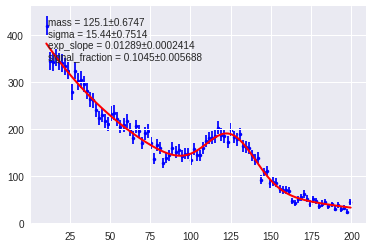

In [22]:
unbinned_likelihood.draw(minuit=minuit);

In [33]:
!pip install Cython
%load_ext Cython

    100% |████████████████████████████████| 2.1MB 9.3MB/s 


In [0]:
%%cython

cimport cython
from libc.math cimport exp, M_PI, sqrt

@cython.binding(True)
def gauss_pdf_cython(double x, double mass, double sigma):
  return 1 / sqrt(2 * M_PI) / sigma * exp(-(x - mass)**2 / 2. / sigma**2)

@cython.binding(True)
def exp_pdf_cython(double x, double exp_slope):
  return exp(-exp_slope * x) * exp_slope

In [66]:
ModelPDF_cython = probfit.AddPdfNorm(gauss_pdf_cython, exp_pdf_cython, facname=['signal_fraction'])
normed_pdf_cython = probfit.Normalized(ModelPDF_cython, mass_bound)
print(iminuit.describe(normed_pdf_cython))

['x', 'mass', 'sigma', 'exp_slope', 'signal_fraction']


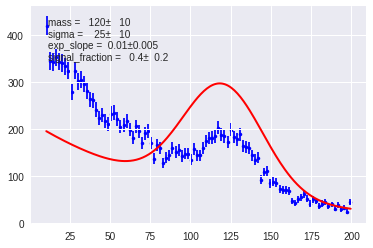

In [67]:
unbinned_likelihood_cython = probfit.UnbinnedLH(normed_pdf_cython, data)

minuit_cython = iminuit.Minuit(
                    unbinned_likelihood_cython,
                    **initial_par_values, **limits, **errors)

unbinned_likelihood_cython.draw(minuit=minuit_cython);

In [68]:
%timeit -n1 -r1 minuit_cython.migrad()

FCN = 83481.08305811606 
 TOTAL NCALL = 183 
 NCALLS = 183 
 
 
 EDM = 7.673077773161731e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,125.12,0.674671,,,50,200,No
1,sigma,15.4371,0.751386,,,3,150,No
2,exp_slope,0.0128911,0.000241409,,,0.0001,1,No
3,signal_fraction,0.104497,0.00568799,,,0,1,No


1 loop, best of 1: 3.45 s per loop


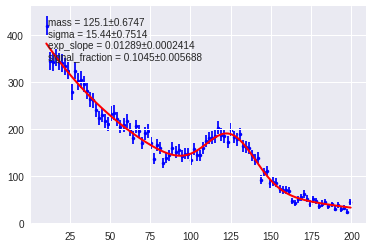

In [69]:
unbinned_likelihood_cython.draw(minuit=minuit_cython);